# **ML project: Identifying Cyberbullying tweets with NLP**

### We will analyze a dataset containing cyberbullying Tweets and create the best model to predict if a text contains cyberbullying or not.

### DATASET: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data

## CONTENTS:
### 1. **TRADITIONAL ML (TFID Vectorizer, Logistic Regression)**
### 2. **LSTM Model -> Long short term memory**
### 3. **TRANFORMERS model**
### 4. **TEXT EXPLAINER**
### 5. **CONCLUSION**

#### Import necessary libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Text cleaning
import re
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

In [4]:
# Models
from sklearn.linear_model import LogisticRegression
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Dropout, Flatten, Activation, BatchNormalization,Input,Embedding, GlobalMaxPooling1D, MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

## Exploratory Data Analysis (**EDA**)

In [48]:
df = pd.read_csv('cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


Checking for duplicated values

In [26]:
df.duplicated().sum()

36

Let's remove them

In [27]:
df = df[~df.duplicated()]

Checking for Null values

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39571 entries, 0 to 47691
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          39569 non-null  object
 1   type          39571 non-null  object
 2   type_encoded  39571 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


No NaNs :)

Let's remove the column the generic column other_cyberbullying

In [29]:
df = df[df["cyberbullying_type"]!="other_cyberbullying"]

## Comments divided by category of cyberbullying:

We can see about 8k tweets for every category

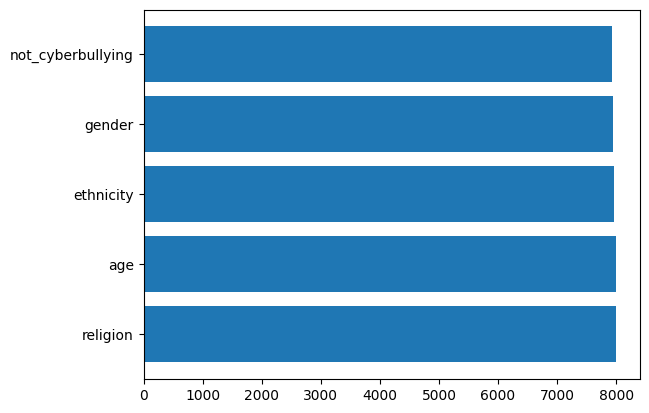

In [30]:
plt.barh(df.cyberbullying_type.value_counts().index, df.cyberbullying_type.value_counts());

Label Encoder for classifying Tweets

In [31]:
# Encoding the labels

labelencoder = LabelEncoder()

df['type_encoded'] = labelencoder.fit_transform(df['cyberbullying_type'])
df[['cyberbullying_type', 'type_encoded']].value_counts()

cyberbullying_type  type_encoded
religion            4               7997
age                 0               7992
ethnicity           1               7959
gender              2               7948
not_cyberbullying   3               7937
Name: count, dtype: int64

Let's rename the columns in: Text and Type for easier understanding

In [32]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'type'})

We have more than 31k cyberbullying tweets and almost 8k not cyberbullying tweets.

In [33]:
df.type.value_counts()

type
religion             7997
age                  7992
ethnicity            7959
gender               7948
not_cyberbullying    7937
Name: count, dtype: int64

Let's do some cleaning!

In [34]:
# Clean the data
def clean_text(text):
    
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    
    # Remove URLs, mentions, and hashtags from the text
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    
    # Tokenize the text
    words = nltk.word_tokenize(text)
    
    # Remove stopwords
    words = [w for w in words if w not in stopwords.words('english')]
    
    # Stem the words
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    
    # Join the words back into a string
    text = ' '.join(words)
    return text

In [35]:
# Apply the cleaning

df['text'] = df['text'].apply(clean_text)

Let's check again for duplicated values or NaNs

In [58]:
df.duplicated().sum()

0

In [57]:
df.isna().value_counts()

text   type   type_encoded
False  False  False           39569
Name: count, dtype: int64

Let's remove them

In [7]:
df = df[~df.duplicated()]

In [8]:
df = df.dropna()

## Visualization of the lenght of Tweets

#### The tweets are shorter than 50 words

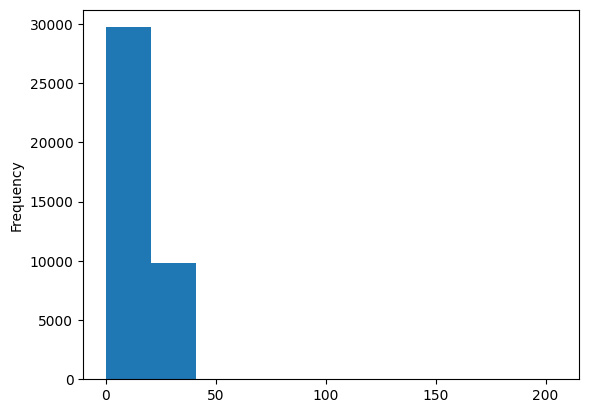

In [38]:
df['text'].apply(lambda x: len(x.split())).plot(kind='hist');

Let's save our cleaned Dataframe now

In [9]:
df.to_csv('cleaned_data.csv')

# 1. **Baseline linear model**

## Accuracy: **93.2%**

In [5]:
df = pd.read_csv('cleaned_data.csv', index_col='Unnamed: 0')

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1579
           1       0.98      0.98      0.98      1570
           2       0.95      0.88      0.92      1578
           3       0.83      0.88      0.85      1629
           4       0.96      0.94      0.95      1558

    accuracy                           0.93      7914
   macro avg       0.93      0.93      0.93      7914
weighted avg       0.93      0.93      0.93      7914



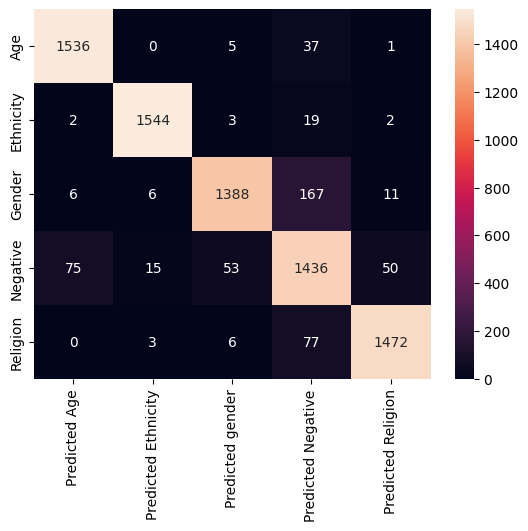

In [62]:
X = df['text']
y = df['type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression())])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted Age', 'Predicted Ethnicity', 'Predicted gender', 'Predicted Negative', 'Predicted Religion'],
            yticklabels=['Age', 'Ethnicity', 'Gender', 'Negative', 'Religion']);

In [64]:
accuracy_score(y_test, y_pred)

0.9320192064695476

# 2. **LSTM model**

## Accuracy: **94%**

In [115]:
df = pd.read_csv('cleaned_data.csv', index_col='Unnamed: 0')
df.head()

,text,type,type_encoded
0,word katandandr food crapilici mkr,not_cyberbullying,3
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying,3
2,xochitlsuckkk classi whore red velvet cupcak,not_cyberbullying,3
3,jason gio meh p thank head concern anoth angri...,not_cyberbullying,3
4,rudhoeenglish isi account pretend kurdish acco...,not_cyberbullying,3


In [65]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['text'])

seq = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(seq, padding='post')
y = df['type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [66]:
print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (39569, 184), X_min: 0, X_max: 9999


In [67]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25324, 184) (7914, 184) (25324,) (7914,)


In [92]:
X = pad_sequences(seq, padding='post')
y = df['type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
optimizer = keras.optimizers.Adam(learning_rate=0.00001)

In [93]:
i = Input(shape=[None])
x = Embedding(input_dim=10000, output_dim=128)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(5, activation='sigmoid')(x)
model = Model(i, x)

# Save the best model

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint_path = "model_checkpoint.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 128)         1280000   
                                                                 
 conv1d_18 (Conv1D)          (None, None, 32)          12320     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, None, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_19 (Conv1D)          (None, None, 64)          6208      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, None, 64)          0         
 ng1D)                                                     

In [110]:
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=15, 
          validation_data=(X_valid,y_valid), 
          callbacks=[model_checkpoint, early_stopping])
model.summary()

Epoch 1/15
396/396 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9792
Epoch 1: val_accuracy did not improve from 0.93082
396/396 [==============================] - 16s 41ms/step - loss: 0.0695 - accuracy: 0.9792 - val_loss: 0.2152 - val_accuracy: 0.9284
Epoch 2/15
396/396 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9801
Epoch 2: val_accuracy did not improve from 0.93082
396/396 [==============================] - 15s 38ms/step - loss: 0.0676 - accuracy: 0.9801 - val_loss: 0.2157 - val_accuracy: 0.9289
Epoch 3/15
396/396 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9808
Epoch 3: val_accuracy did not improve from 0.93082
396/396 [==============================] - 15s 39ms/step - loss: 0.0659 - accuracy: 0.9808 - val_loss: 0.2169 - val_accuracy: 0.9288
Epoch 4/15
396/396 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9814
Epoch 4: val_accuracy did not improve from 0.93082
396/396 [====

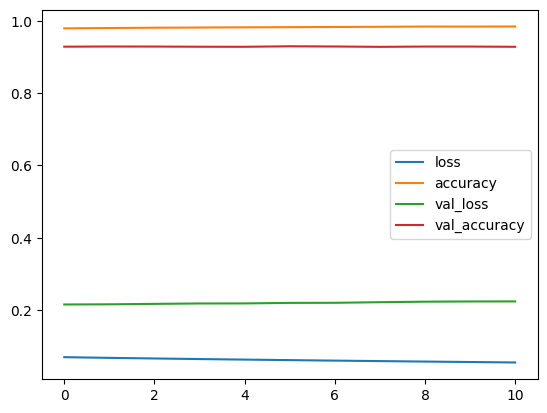

In [111]:
pd.DataFrame(history.history).plot();

248/248 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1579
           1       0.98      0.99      0.99      1570
           2       0.94      0.89      0.91      1578
           3       0.85      0.89      0.87      1629
           4       0.96      0.95      0.95      1558

    accuracy                           0.94      7914
   macro avg       0.94      0.94      0.94      7914
weighted avg       0.94      0.94      0.94      7914



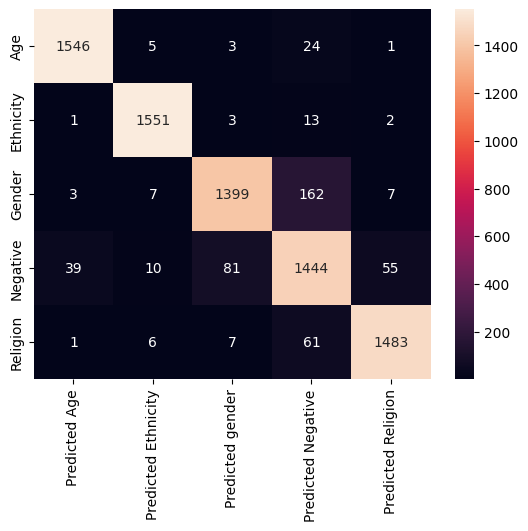

In [112]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted Age', 'Predicted Ethnicity', 'Predicted gender', 'Predicted Negative', 'Predicted Religion'],
            yticklabels=['Age', 'Ethnicity', 'Gender', 'Negative', 'Religion']);

In [114]:
print(accuracy_score(y_test, y_pred))

0.9379580490270407


# 3. **Transformer model**

## Accuracy: **93%**

In [14]:
X = df['text']
y = df['type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [16]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [17]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['text'])
seq = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(seq, padding='post')
y = df['type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [122]:
embed_dim = 50  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 184
vocab_size = 39571

## Using Sequential API
model = keras.Sequential()
model.add(Input(shape=(maxlen, )))
model.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim,  rate=0.45))

model.add(GlobalAveragePooling1D())
model.add(Dropout(0.25))
model.add(Dense(ff_dim, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

# Save the best model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = "model_checkpoint.h6"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

In [123]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [125]:
history = model.fit(X_train,
                    y_train,
                    batch_size=256,
                    epochs=6,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping, model_checkpoint])

Epoch 1/6
99/99 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9796
Epoch 1: val_accuracy did not improve from 0.92987
99/99 [==============================] - 118s 1s/step - loss: 0.0749 - accuracy: 0.9796 - val_loss: 0.4052 - val_accuracy: 0.9228
Epoch 2/6
99/99 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9832
Epoch 2: val_accuracy did not improve from 0.92987
99/99 [==============================] - 80s 814ms/step - loss: 0.0601 - accuracy: 0.9832 - val_loss: 0.4107 - val_accuracy: 0.9239
Epoch 3/6
99/99 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9859
Epoch 3: val_accuracy did not improve from 0.92987
99/99 [==============================] - 90s 911ms/step - loss: 0.0532 - accuracy: 0.9859 - val_loss: 0.4466 - val_accuracy: 0.9217
Epoch 4/6
99/99 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9861
Epoch 4: val_accuracy did not improve from 0.92987
99/99 [=======================

248/248 [==============================] - 10s 37ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1579
           1       0.98      0.98      0.98      1570
           2       0.91      0.90      0.90      1578
           3       0.87      0.82      0.85      1629
           4       0.92      0.97      0.95      1558

    accuracy                           0.93      7914
   macro avg       0.93      0.93      0.93      7914
weighted avg       0.93      0.93      0.93      7914



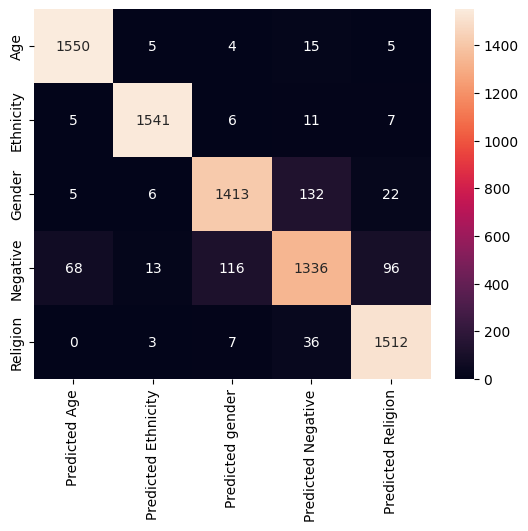

In [126]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted Age', 'Predicted Ethnicity', 'Predicted gender', 'Predicted Negative', 'Predicted Religion'],
            yticklabels=['Age', 'Ethnicity', 'Gender', 'Negative', 'Religion']);

In [127]:
print(accuracy_score(y_test, y_pred))

0.9289866060146575


# **Text Explainer**

In [9]:
explainer = LimeTextExplainer(class_names=list(df['type'].unique()))
maxlen = 184
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen = maxlen)
    return np.array(model.predict(np.array(_seq_pad)))

In [21]:
df.text[34534]

'poor kid high school life ruin forev imagin video pop guy teas bulli till drop dead'

In [22]:
df.type[34534]

'age'

In [19]:
model = keras.models.load_model('model_checkpoint.h5')

In [23]:
exp = explainer.explain_instance(df.text[34534],
                                 classifier_fn=model_predict_pipeline,
                                 num_features=10000,
                                 top_labels=5)

exp.show_in_notebook(text=True)

157/157 [==============================] - 2s 9ms/step


In [55]:
import pickle
cyberbullying_types = {
        0: 'age',
        1: 'ethnicity',
        2: 'gender',
        3: 'not_cyberbullying',
        4: 'religion'}

#Assuming you have a saved tokenizer and model
with open('tokenizer.h5', 'rb') as file:
    tokenizer = pickle.load(file) # Replace with your actual loading mechanism
model = load_model('model_checkpoint.h5')  #Replace with your actual loading mechanism

#Text to be predicted
input_text = 'hello girly sunshine'

#Tokenize the input text
input_sequence = tokenizer.texts_to_sequences([input_text])

#Ensure the sequence has the same length as the input length during training
max_sequence_length = 184  # Replace with your actual sequence length
input_sequence = pad_sequences(input_sequence, maxlen = max_sequence_length)

#Convert the sequence to a numpy array
input_data = np.array(input_sequence)

#Make predictions
predictions = model.predict(input_data)

#Print or use the predictions as needed
print(predictions)
print(cyberbullying_types)

1/1 [==============================] - 0s 341ms/step
[[0.02624862 0.09192101 0.86446536 0.98414236 0.16431934]]
{0: 'age', 1: 'ethnicity', 2: 'gender', 3: 'not_cyberbullying', 4: 'religion'}


# **CONCLUSION**

#### Following an extensive analysis leveraging Machine Learning models, our findings indicate the optimal utilization of our LSTM model, exhibiting an excellent accuracy rate of 94%.